# Pool-based sampling with CIFAR10

In [1]:
pip install modal

In [2]:
import numpy as np

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from functools import partial
from modAL.batch import uncertainty_batch_sampling

from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# imports the cifar files
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
# returns a image rgb array, label and label's name of the image with index im_idx
def cifar10_img_info(data, meta, im_idx=0):
    im = data[b'data'][im_idx, :]

    im_r = im[0:1024].reshape(32, 32)
    im_g = im[1024:2048].reshape(32, 32)
    im_b = im[2048:].reshape(32, 32)

    img = np.dstack((im_r, im_g, im_b))
    label = data[b'labels'][im_idx]
    category = meta[b'label_names'][data[b'labels'][im_idx]]

    return img, label, category

In [5]:
# returns a image rgb array
def img_reshape(im):
    im_r = im[0:1024].reshape(32, 32)
    im_g = im[1024:2048].reshape(32, 32)
    im_b = im[2048:].reshape(32, 32)

    img = np.dstack((im_r, im_g, im_b))
    
    return img

In [6]:
# returns X and y of the dataset, X.shape = (nº of samples x features) and y.shape = (nº of samples)
def batch_to_xy(batch):
    X = batch[b"data"]
    y = batch[b"labels"]
    y = np.array(y)
    y.reshape(y.shape[0])
    return X, y

## The dataset

In [10]:
# batch with 10000 examples
batch1 = unpickle("data_batch_1")
# meta has the labels' names
meta = unpickle("batches.meta")

Showing a example from the batch

In [11]:
# change this to see another example
img_idx = 45

In [12]:
img_ex, label_ex, category_ex = cifar10_img_info(batch1, meta, img_idx)

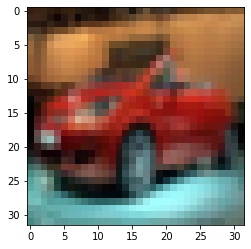

In [13]:
plt.imshow(img_ex)

In [14]:
print("Label: "+str(label_ex)+"\nCategory: "+str(category_ex))

Label: 1
Category: b'automobile'



# **Preparing the dataset**

In [16]:
X_raw, Y_raw = batch_to_xy(batch1)

In [17]:
X_raw.shape

(10000, 3072)

In [18]:
Y_raw.shape

(10000,)

In [19]:
#APPLY PCA
#https://towardsdatascience.com/integration-of-dimension-reduction-methods-and-neural-network-for-image-classification-96281963fe24
#99% -> 658
#95% -> 217
#90% -> 99
#80% -> 21
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)
pca = PCA(n_components=21, random_state=RANDOM_STATE_SEED)
tf_X = pca.fit_transform(X=X_raw)

In [20]:
tf_X.shape

(10000, 21)

In [21]:
X_raw = tf_X
X_raw.shape

(10000, 21)

In [22]:
# Isolate our examples for our labeled dataset.
n_labeled = X_raw.shape[0]   #Number of samples
training_indices = np.random.randint(low=0, high=n_labeled + 1, size=1000)
#print(training_indices)

In [23]:
X_train = X_raw[training_indices]
y_train = Y_raw[training_indices]
X_train.shape

(1000, 21)

In [24]:
# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(Y_raw, training_indices, axis=0)

In [25]:
X_pool.shape

(9046, 21)

In [26]:
y_pool.shape

(9046,)

In [27]:
# Specify our core estimator.
knn = KNeighborsClassifier(n_neighbors=3)

In [28]:
# Pre-set our batch sampling to retrieve 3 samples at a time.
BATCH_SIZE = 400
preset_batch = partial(uncertainty_batch_sampling, n_instances=BATCH_SIZE)

## Initializing the learner

In [29]:
learner = ActiveLearner(
    estimator=knn,
    X_training=X_train,
    y_training=y_train,
    query_strategy=preset_batch
)

From the examples: "We also set how many queries we want to make. The more the better! (Usually :) )"

In [30]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == Y_raw)


In [31]:
print(is_correct)

[ True False  True ...  True False False]


In [32]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw, Y_raw)

In [33]:
print(unqueried_score)

0.2844


In [38]:
N_RAW_SAMPLES = X_pool.shape[0]
N_QUERIES = N_RAW_SAMPLES // BATCH_SIZE
print(N_RAW_SAMPLES)
print(N_QUERIES)

9046
22


In [39]:
performance_history = [unqueried_score]
print(performance_history)

[0.2844]


## The active learning loop

In [40]:
for index in range(N_QUERIES):
    query_index, query_instance = learner.query(X_pool)

    # Teach our ActiveLearner model the record it has requested.
    X, y = X_pool[query_index], y_pool[query_index]
    learner.teach(X=X, y=y)

    # Remove the queried instance from the unlabeled pool.
    X_pool = np.delete(X_pool, query_index, axis=0)
    y_pool = np.delete(y_pool, query_index)

    # Calculate and report our model's accuracy.
    model_accuracy = learner.score(X_raw, Y_raw)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
    # Save our model's performance for plotting.
    performance_history.append(model_accuracy)
   


Accuracy after query 1: 0.3047
Accuracy after query 2: 0.3227
Accuracy after query 3: 0.3422
Accuracy after query 4: 0.3594
Accuracy after query 5: 0.3767
Accuracy after query 6: 0.3983
Accuracy after query 7: 0.4130
Accuracy after query 8: 0.4320
Accuracy after query 9: 0.4457
Accuracy after query 10: 0.4579
Accuracy after query 11: 0.4721
Accuracy after query 12: 0.4873
Accuracy after query 13: 0.5044
Accuracy after query 14: 0.5195
Accuracy after query 15: 0.5306
Accuracy after query 16: 0.5429
Accuracy after query 17: 0.5530
Accuracy after query 18: 0.5618
Accuracy after query 19: 0.5716
Accuracy after query 20: 0.5809
Accuracy after query 21: 0.5903
Accuracy after query 22: 0.5945


In [48]:
performance_history

[0.2844,
 0.3047,
 0.3227,
 0.3422,
 0.3594,
 0.3767,
 0.3983,
 0.413,
 0.432,
 0.4457,
 0.4579,
 0.4721,
 0.4873,
 0.5044,
 0.5195,
 0.5306,
 0.5429,
 0.553,
 0.5618,
 0.5716,
 0.5809,
 0.5903,
 0.5945]

We can visualize the accuracy during the training.

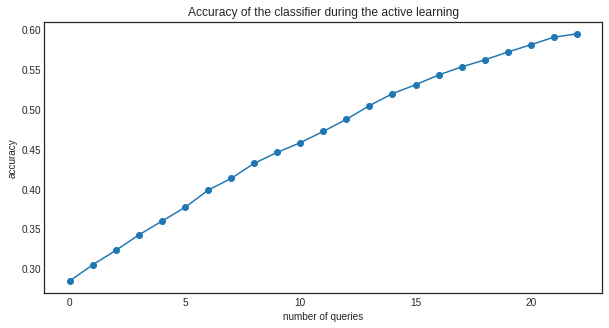

In [51]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.title('Accuracy of the classifier during the active learning')
    plt.plot(range(N_QUERIES+1), performance_history)
    plt.scatter(range(N_QUERIES+1), performance_history)
    plt.xlabel('number of queries')
    plt.ylabel('accuracy')
    plt.show()